# Here we implements a network inspired by InceptionResnet And train it on edge-extracted images. I wanted to test the methods for signature authentication found in literatures 

In [ ]:
import torch
import torchvision
import torch.nn as nn
from torch import optim
from torchvision import transforms, models, datasets
from torch.utils.data import DataLoader, Dataset

import cv2, glob, numpy as np, pandas as pd

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
img_size = 512
label_dict = {"real":0, "fake":1}

def parent_dir(item):
    return [item.rsplit('/')[-2]]

def edge_img(img):
  # This function uses Scharr filters to extract edges
  gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  gray_blrd = cv2.medianBlur(gray_img, 15)

  grad_x = cv2.Scharr(gray_blrd, ddepth=cv2.CV_8U, dx=1, dy=0)
  grad_y = cv2.Scharr(gray_blrd, ddepth=cv2.CV_8U, dx=0, dy=1)

  abs_grad_x = cv2.convertScaleAbs(grad_x)
  abs_grad_y = cv2.convertScaleAbs(grad_y)

  grad = cv2.addWeighted(abs_grad_x, 0.4, abs_grad_y, 0.6, 0)
  return grad

import torchvision.transforms.functional as TF
import random

class Rotation:
    def __init__(self, angles):
        self.angles = angles

    def __call__(self, x):
        angle = random.choice(self.angles)
        return TF.rotate(x, angle)

class Translate:
    def __init__(self, pixels):
        self.pixels = pixels
        self.angle = 0.

    def __call__(self, x):
        pix = random.choice(self.pixels)
        return TF.affine(x, self.angle, (pix,pix), scale=1, shear=0.)


rot = Rotation(angles=[-45, -30, -15, 0, 15, 30, 45])
trans = Translate(pixels=[-25, -35, 15, 30])



class LV_KhakiDataset(Dataset):
    def __init__(self, folder):
        self.folder = folder
        self.items = glob.glob(f'{self.folder}/*/*') 

    def __getitem__(self, ix):
        item = self.items[ix]
        img = cv2.imread(item)
        img = edge_img(img)
        img = cv2.resize(img, (img_size,img_size))
        img = torch.tensor(img).unsqueeze_(0).float()
        img = (img - torch.mean(torch.mean(img))) / torch.std(img)
        target = label_dict[parent_dir(item)[0]]
        if target == 1:
          img = rot(img)
          img = trans(img)
        return img.to(device), torch.tensor([target]).to(device)
    
    def __len__(self):
        return len(self.items)


In [ ]:

from torch.nn.modules.batchnorm import BatchNorm2d
from torch.nn.modules.conv import Conv2d
class LV_Classifier(nn.Module):
    def __init__(self):
        super(LV_Classifier, self).__init__()
        self.conv1_2x2 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=2, padding=0, stride=2)
        self.conv1_3x3 = nn.Conv2d(1,16,3,padding=1,stride=2)
        self.conv1_5x5 = nn.Conv2d(1,16,5,padding=2,stride=2)
        self.Mp1_2x2 = nn.MaxPool2d(kernel_size=2, padding=0, stride=2)

        self.conv2_2x2 = nn.Conv2d(in_channels=49, out_channels=64, kernel_size=2, padding=0, stride=2)
        self.conv2_3x3 = nn.Conv2d(49,64,3,padding=1,stride=2)
        self.conv2_5x5 = nn.Conv2d(49,64,5,padding=2,stride=2)
        self.Mp2_2x2 = nn.MaxPool2d(kernel_size=2, padding=0, stride=2)

        self.fconv_1x1 = nn.Conv2d(241,64,1,padding=0,stride=1)

        self.drop = nn.Dropout(0.2)
        self.avg_pool = nn.AvgPool2d(kernel_size=3,padding=1,stride=2)
        self.b_norm1 = nn.BatchNorm2d(num_features=49)
        self.b_norm2 = nn.BatchNorm2d(num_features=241)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64*16*16, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 2, bias=False)
        self.active = nn.LogSoftmax(dim=1)

        self.loss_fn = nn.NLLLoss()

    def forward(self, x):
        
        x1 = self.conv1_2x2(x)
        x2 = self.conv1_3x3(x)
        x3 = self.conv1_5x5(x)
        m1 = self.Mp1_2x2(x)
        z = torch.cat((x1,x2,x3,m1),1)
        z = self.drop(z)
        z = self.avg_pool(z)
        z = self.b_norm1(z)

        z1 = self.conv2_2x2(z)
        z2 = self.conv2_3x3(z)
        z3 = self.conv2_5x5(z)
        m2 = self.Mp2_2x2(z)
        z = torch.cat((z1,z2,z3,m2),1)
        z = self.drop(z)
        z = self.avg_pool(z)
        z = self.b_norm2(z)

        z = self.fconv_1x1(z)

        z = self.flatten(z)
        z = self.fc1(z)
        z = self.drop(z)
        z = self.relu(z)
        z = self.fc2(z)
        #z = self.drop(z)
        z = self.relu(z)
        z = self.fc3(z)
        z = self.relu(z)
        #out = self.sigmoid(z)
        out = self.active(z)
        return out

    def compute_metrics(self, preds, targets):
      loss = self.loss_fn(preds, targets.squeeze())
      _, indices = torch.max(preds.data, 1)
      acc = (indices == targets).float().mean().to(device)
      return loss, acc

In [ ]:
folder = "/content/drive/MyDrive/khaki/"
trn_ds = LV_KhakiDataset(folder=folder+"train")
val_ds = LV_KhakiDataset(folder=folder+"val")

trn_dl = DataLoader(trn_ds, shuffle=True, batch_size=16)
val_dl = DataLoader(val_ds, shuffle=False, batch_size=16)

torch.Size([1, 512, 512])
tensor([1], device='cuda:0')


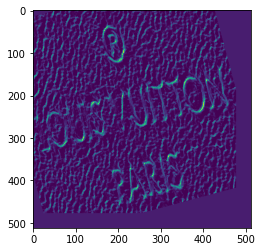

In [ ]:
import matplotlib.pyplot as plt
im, label = val_ds[150]
print(im.shape)
plt.imshow(im[0,:,:].cpu())
print(label)

In [ ]:
def train_batch(x, y, model, optimizer, criterion):
    model.train()
    pred = model(x)
    optimizer.zero_grad()
    loss, acc = criterion(pred, y)
    loss.backward()
    #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=100., norm_type=2)
    optimizer.step()
    return loss.item(), acc.item()

In [ ]:
@torch.no_grad()
def validate_batch(x, y, model, criterion):
    model.eval()
    pred = model(x)
    loss, acc = criterion(pred, y)
    return loss.item(), acc.item()

In [ ]:
#model = LV_Classifier().to(device)
model = torch.load('/content/drive/MyDrive/khaki/trained_models/Rebag_Incept_nll_6.pth').to(device)
criterion = model.compute_metrics
#optimizer = optim.Adam(model.parameters(),lr = 0.001)
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

In [ ]:
# following two cells install some handy packages that helps us to track the training process neatly
!pip install torch_snippets

In [ ]:
!pip install jsonlines

# We have three different cells for train loop. The differences are minor and either of them can be used to train the model

In [ ]:

from torch_snippets import *
from torch.optim.lr_scheduler import ReduceLROnPlateau, MultiStepLR
scheduler1 = MultiStepLR(optimizer, milestones=[10,20,30,40,50], gamma=0.1)
scheduler2 = ReduceLROnPlateau(optimizer, mode='min', patience=5)
n_epochs = 60
log = Report(n_epochs)

for ex in range(n_epochs):
    N = len(trn_dl)
    for bx, batch in enumerate(trn_dl):
      x, y = batch
      loss, acc = train_batch(x, y, model, optimizer, criterion)
      log.record(ex+(bx+1)/N, trn_loss=loss, trn_acc=acc, end='\r')
      if (ex+1)%10==0: scheduler1.step()

    N = len(val_dl)
    for bx, batch in enumerate(val_dl):
      x, y = batch
      loss, acc = validate_batch(x, y, model, criterion)
      log.record(ex+(bx+1)/N, val_loss=loss, val_acc=acc, end='\r')
      scheduler2.step(loss) 
    if (ex+1)%10==0: log.report_avgs(ex+1)
    if (ex+1)%20==0: torch.save(model, '/content/drive/MyDrive/khaki/trained_models/Rebag_Incept_nll_7.pth')
#log.report_avgs(ex+1)

In [ ]:
torch.save(model, '/content/drive/MyDrive/khaki/trained_models/Rebag_Incept1.pth')

In [ ]:
model = torch.load('/content/drive/MyDrive/khaki/trained_models/Rebag_Incept_nll_3.pth')

In [ ]:
optimizer = optim.Adamax(model.parameters(), lr=0.0002, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

In [ ]:
#from torch.optim import lr_scheduler
from torch_snippets import *
n_epochs = 100
log = Report(n_epochs)

#scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

for ex in range(n_epochs):
    N = len(trn_dl)
    for bx, batch in enumerate(trn_dl):
      x, y = batch
      loss, acc = train_batch(x, y, model, optimizer, criterion)
      log.record(ex+(bx+1)/N, trn_loss=loss, trn_acc=acc, end='\r')

    N = len(val_dl)
    for bx, batch in enumerate(val_dl):
      x, y = batch
      loss, acc = validate_batch(x, y, model, criterion)
      log.record(ex+(bx+1)/N, val_loss=loss, val_acc=acc, end='\r')

    if (ex+1)%10==0: log.report_avgs(ex+1)
    if (ex+1)%50==0: torch.save(model, '/content/drive/MyDrive/khaki/trained_models/Rebag_Incept2.pth')
    #if (ex+1)%20==0: scheduler.step()

In [ ]:
from torch_snippets import *
train_losses, train_accuracies = [], []
val_accuracies = []
n_epochs = 100
log = Report(n_epochs)
N = len(trn_dl)

for epoch in range(n_epochs):
    #print(f" epoch {epoch + 1}/5")
    train_epoch_losses, train_epoch_accuracies = [], []
    val_epoch_accuracies = []

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss) 
    train_epoch_loss = np.array(train_epoch_losses).mean()
    log.record(epoch+(1+ix)/N, trn_loss=train_epoch_loss, end='\r')

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct) 
    train_epoch_accuracy = np.mean(train_epoch_accuracies)
    log.record(epoch+(1+ix)/N, trn_acc=train_epoch_accuracy, end='\r')

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        val_epoch_accuracies.extend(val_is_correct)
    val_epoch_accuracy = np.mean(val_epoch_accuracies)
    log.record(epoch+(1+ix)/N, val_acc=val_epoch_accuracy, end='\r')

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_accuracies.append(val_epoch_accuracy)

EPOCH: 99.176	val_acc: 0.691	(13990.39s - 116.17s remaining)

# Making test data set and implementing test phase

In [ ]:
test_ds = LV_KhakiDataset(folder=folder+"test")

test_dl = DataLoader(test_ds, shuffle=False, batch_size=1)

In [ ]:
dataiter = iter(test_dl)
labels = []
preds = []

for i in range(len(test_dl)):
    img, label = next(dataiter)
    img, label = img.to(device), label.to(device)
    pred = model(img)
    _, indices = torch.max(pred.data, 1)
    is_correct = (indices == label).float()
    #is_correct = ((pred >= 0.5) == label).float()
    preds.append(is_correct), labels.append(label.item())

tensor([1], device='cuda:0')


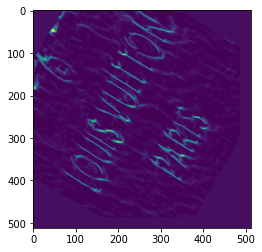

In [ ]:
img, label = test_ds[133]
print(label)
plt.imshow(img[0,:,:].cpu())

In [ ]:
def confusion(prediction, truth):
    """ Returns the confusion matrix for the values in the `prediction` and `truth`
    tensors, i.e. the amount of positions where the values of `prediction`
    and `truth` are
    - 1 and 1 (True Positive)
    - 1 and 0 (False Positive)
    - 0 and 0 (True Negative)
    - 0 and 1 (False Negative)
    """

    confusion_vector = prediction / truth
    # Element-wise division of the 2 tensors returns a new tensor which holds a
    # unique value for each case:
    #   1     where prediction and truth are 1 (True Positive)
    #   inf   where prediction is 1 and truth is 0 (False Positive)
    #   nan   where prediction and truth are 0 (True Negative)
    #   0     where prediction is 0 and truth is 1 (False Negative)

    true_positives = torch.sum(confusion_vector == 1).item()
    false_positives = torch.sum(confusion_vector == float('inf')).item()
    true_negatives = torch.sum(torch.isnan(confusion_vector)).item()
    false_negatives = torch.sum(confusion_vector == 0).item()

    return true_positives, false_positives, true_negatives, false_negatives

In [ ]:
confusion(torch.Tensor(preds), torch.Tensor(labels))

(59, 128, 5, 1)